In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma as gamma_func
from scipy.optimize import fsolve
from scipy.stats import gamma
from tqdm.auto import tqdm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Gamma Gamma


From [Codes for Unit 4: gammagamma.m](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture videos: [Unit 4 Lesson 10: Credible Sets](https://www.youtube.com/watch?v=AV7PtxWQYVw&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=27) and [Unit 4 Lesson 11](https://www.youtube.com/watch?v=kXRS22YMrSk&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=28).

Professor Vidakovic usually calls them credible sets. If you search for more information online, you'll see a lot of terms thrown around: Bayesian credible intervals or just credible intervals, highest density regions, highest posterior density intervals (HDPI) or just highest density intervals (HDI), percentile intervals, and compatibility intervals. Not to be confused with confidence intervals!

These terms don't all mean exactly the same thing. For our class, the main distinction the professor draws is between HPD-credible sets and equitailed credible sets. Sometimes the homework will ask for one or the other, or both, so make sure you understand the difference. If the homework doesn't specify, you can use either, but the equitailed credible set is easier to calculate.

## Translation of MATLAB code (magic k)
First, here's a direct translation from the MATLAB code. The professor didn't include how to find $k(\alpha)$ in this version.

In [2]:
def gamma_pdf(x, a, b):
    """
    Gamma pdf
    
    x: numpy array or float
    a: int or float. shape (α)
    b: int or float. rate (β)
    
    returns a numpy array or float
    """
    return 1/gamma_func(a) * x**(a - 1) * b**a * np.exp(-b*x)

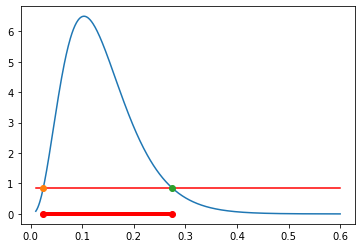

In [3]:
# figure 1

# unlike MATLAB i:j:k syntax, arange is not inclusive at the high end
xx = np.arange(.01, .601, .001)
a = 4
b = 29

# curve
plt.plot(xx, gamma_pdf(xx, a, b))

# additional markings
plt.plot(xx, np.full_like(xx, .857), 'r-')
plt.plot(.0246, gamma_pdf(.0246, a, b), 'o')
plt.plot(.0246, 0, 'ro')
plt.plot(.2741, gamma_pdf(.2741, a, b), 'o')
plt.plot(.2741, 0, 'ro')
plt.plot([0.0246, 0.2741], [0, 0], 'r-', linewidth=4)
plt.show()

In [5]:
# hpd credible set

k = .857368863848

lower_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.05)[0]
upper_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.4)[0]
print(f'HPD credible set: [{lower_hpd} {upper_hpd}]')

prob_hpd = gamma.cdf(upper_hpd, a, scale=1/b) - gamma.cdf(lower_hpd, a, scale=1/b)
print(f'Probability within hpd bounds: {prob_hpd}')
print(f'length of hpd cs: {upper_hpd - lower_hpd}')


HPD credible set: [0.024568994513107345 0.27407917790064784]
Probability within hpd bounds: 0.9500000000000202
length of hpd cs: 0.2495101833875405


In [ ]:
from scipy.optimize import fsolve
from scipy.stats import gamma
import numpy as np

# our pdf is Gamma(4, 1/29) where 29 is the rate.
# looking at the plot, k must be between 0-2

a = 4
b = 29
alpha = 0.05
tolerance = 0.0001

possible_k = np.arange(0.01, 2, tolerance)

for k in tqdm(possible_k):
    lower = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, 0.05)[0]
    upper = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, 0.4)[0]
    prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)
    if abs(prob - (1 - alpha)) <= tolerance:
        print(f"{k=}")
        print(f"HPD credible set: {lower, upper}")
        print(f"length = {upper - lower}")
        print(f"probability within these bounds: {prob}")
        break

  0%|          | 0/19900 [00:00<?, ?it/s]

In [ ]:
# equi-tailed credible set

# percent point function aka quantile aka inverse cdf
lower_eqt = gamma.ppf(.025, a, scale=1/b)
upper_eqt = gamma.ppf(.975, a, scale=1/b)
print(f'Equitailed credible set: [{lower_eqt} {upper_eqt}]')

prob_eqt = gamma.cdf(upper_eqt, a, scale=1/b) - gamma.cdf(lower_eqt, a, scale=1/b)
print(f'Probability within eqt bounds: {prob_eqt}')
print(f'length of eqt cs: {upper_eqt - lower_eqt}')


In [ ]:
# figure 2

# curve
plt.plot(xx, gamma_pdf(xx, a, b), 'k-', linewidth=2)

plt.plot(lower_eqt, gamma_pdf(lower_eqt, a, b), 'o')
plt.plot(lower_eqt, 0, 'ro')
plt.plot(upper_eqt, gamma_pdf(upper_eqt, a, b), 'o')
plt.plot(upper_eqt, 0, 'ro')
plt.plot([lower_eqt, upper_eqt], [0, 0], 'r-', linewidth=4)
plt.plot([lower_eqt, upper_eqt],
         [gamma_pdf(lower_eqt, a, b), gamma_pdf(upper_eqt, a, b)],
         'k-',
         linewidth=1)
plt.show()

Right now I want to get through these examples so Spring 2022 students can get some use out of them. Later on, I think this example could use a lot more explanation and expansion.

## Find the HPD credible interval when you don't know k

A student in the Spring 2022 class was wondering where the .05 and .4 values entered to ```fsolve()``` came from. They're just your guesses for the lower and upper bounds of the credible interval. They give the optimizer a starting point.

That led to the bigger question of where $k$ came from. What you need to find is $k(α)$, which is a horizontal line that intersects the lower and upper bounds of your HPD credible interval. The reason we want a horizontal line is that this ensures that you've got the shortest interval covering credibility $1 - α$ (we usually choose a credibility of .95 in this course, but that's arbitrary).

I don't know how the professor did it originally, but I do know two methods. First, the optimization method, pretty much just trying lots of values for $k$ (guessing Professor Vidakovic did it this way):

1. Loop over a bunch of possible k values, each time using an equation like fzero() on the pdf of your posterior minus k. This will solve for the location that your pdf intersects with k. You need to feed the optimizer an initial guess, one lower, near the lower bound of the credible interval, and one higher, near the upper bound.

2. Enter each bound into the posterior CDF, subtract the results to get the probability the posterior falls within those bounds. If it's close enough to 1 - α, you can stop the loop because you have your answer. If not, the loop continues.

In [ ]:
# our pdf is Gamma(4, 1/29) where 29 is the rate.
# looking at the plot, k must be between 0-2

a = 4
b = 29
alpha = 0.05
tolerance = 0.0001

# initial guesses
guess_lwr = 0.05
guess_upr = 0.4
possible_k = np.arange(0, 2, tolerance)

# if loop finishes without printing anthing, no solution within given tolerance
# solution: adjust tolerance or initial guesses
for k in tqdm(possible_k):
    lower = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_lwr)[0]
    upper = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_upr)[0]
    prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)
    if abs(prob - (1 - alpha)) <= tolerance:
        print(f"{k=}")
        print(f"HPD credible set: {lower, upper}")
        print(f"length = {upper - lower}")
        print(f"probability within these bounds: {prob}")
        break

This method is really finicky, you might find yourself needing to adjust the tolerance and initial guesses quite a bit. It also wouldn't work as written for any posterior where the HPD credible set wasn't a continuous interval (as discussed in this post), but it could be extended to work for that situation.

There's another way that I find simpler, which involves sampling lots of values from the posterior. I don't have time to write it up now, but I will add it here sometime soon.